In [1]:
import pandas as pd
import numpy as np
import gzip
import seaborn as sns
import matplotlib.pyplot as plt

import os
import itertools
from collections import Counter
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split # module to split our data into train and test sets

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/joelmorley/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [5]:
# Import and tidy dataframe (drop nulls)
df = getDF('qa_Appliances.json.gz')
#df.dropna(subset='answerType', inplace=True)
df = df.reset_index()

In [6]:
df.loc[3,['question','questionType','answerType','answer']]

question        Does this come with power cord and dishwasher ...
questionType                                               yes/no
answerType                                                      ?
answer          It does not come with a power cord. It does co...
Name: 3, dtype: object

In [63]:
df['questionType'].value_counts()

yes/no        4693
open-ended    4318
Name: questionType, dtype: int64

# Supervised Approach

In [9]:
# Map answers to useful/not useful
df['target'] = df['answerType'].map({'Y':1, 'N':1, '?':0})

In [7]:
## Transform a sentence into 1s and 0s
vectorizer = CountVectorizer(analyzer = "word", # What are we looking for?
                             tokenizer = None, # Already tokenised
                             preprocessor = None, # Already pre-processed
                             stop_words = None, # Already removed stopwords
                             max_features = 5000,
                             ngram_range=(1, 2)) # Determines the top X words used for the vectoriser

In [10]:
train_features = vectorizer.fit_transform(df['answer'])
train_features = train_features.toarray()
y_train = df['target'].values
lr = LogisticRegression(max_iter=300)
lr.fit(train_features, y_train)
lr.score(train_features, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [157]:
df.loc[3,['question', 'answer']]

question    Does this come with power cord and dishwasher ...
answer      It does not come with a power cord. It does co...
Name: 3, dtype: object

In [158]:
# Check a single entry, 0 = unhelpful, 1 = helpful
test = vectorizer.transform(df.loc[3,['answer']])
lr.predict(test.toarray())

array([0])

# Unsupervised approach
## Semantic similarity using spacy
### Between characteristic words and the answer

In [11]:
import spacy
nlp = spacy.load('en_core_web_md')

In [13]:
useful_words = 'yes,no,certainly,cant,can'.split(',')
un_words = 'unsure,never,dont,maybe,could'.split(',')

def similarity_test(list,answer):
    """
    Function to test the similarity between all the words of a sentence (answer) and a list of
    words (useful or useless words).
    Output is an average similarity score for the answer, between -1 and 1.
    """
    ans_sim = []
    use_sim = []

    for word in list:
        for term in answer:
            test_word = nlp(word)
            ans_word = nlp(term)
            ans_sim.append(test_word.similarity(ans_word))
        use_sim.append(sum(ans_sim)/len(ans_sim))
        print(word, sum(ans_sim)/len(ans_sim))
    return sum(use_sim)/len(use_sim)

ans = df['answer'][2].lower()
use_score = similarity_test(useful_words,ans.split(' '))
unu_score = similarity_test(un_words,ans.split(' '))

print(ans)
print(f'Useful score: {use_score}, unuseful score: {unu_score}')


yes 0.13041196370449343
no 0.16385734839125388
certainly 0.24757533819159003
cant 0.21731814592739304
can 0.22780956195331006
unsure 0.29856480711758565
never 0.3098429641779861
dont 0.26574813070049624
maybe 0.25987554404895336
could 0.27778213745494096
it does not come with a power cord. it does come with the dishwasher hookup.
Useful score: 0.19739447163360807, unuseful score: 0.28236271669999247


### Between the question and the answer

In [12]:
def qa_sim(question, answer):
    """
    Function to provide a similarity score between two sentences (question and answer),
    returned score is between -1 and 1
    """
    test_question = question
    test_answer = answer

    # Create a token for the test movie and initialise the highest coefficient marker
    q_token = nlp(test_question)
    a_token = nlp(test_answer)

    return q_token.similarity(a_token)

df['sim_score'] = df.apply(lambda x: qa_sim(x.question, x.answer), axis=1)

/var/folders/b7/kmbr2qfj1fd5c0wjsnnd0jtw0000gn/T/ipykernel_20585/3473484234.py:13: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return q_token.similarity(a_token)


KeyboardInterrupt: 

In [10]:
df[['question','answer','sim_score']].sort_values(by='sim_score').head()

,question,answer,sim_score
3774,Does anybody know the inside dimensions?,"Length(front) 19"" Width(side) 15"" Height(depth...",-0.363745
7016,"How loud is this fan, I dont see the Scones li...",Low speed: 25 dba (0.4sones) to Max speed: 56d...,-0.347375
2473,WILL THIS FIT MODEL (P) MSD2641KEB ?,"Hey William, not sure what your model is, but ...",-0.286926
3570,Can I stack a 4-Inch by 4-Inch by 14.5-Inch on...,Yes,-0.276408
2355,WILL THIS FIT MODEL (P) MSD2641KEB ?,If it is in an icemaker model that fits in you...,-0.262069


In [11]:
df[['question','answer','sim_score']].sort_values(by='sim_score').tail()

,question,answer,sim_score
5533,Does this product come with all the items show...,"Yes, This product come with all the items show...",0.956205
2988,I know the washer has a manual override where ...,Yes. What I do sometimes is I just use the ext...,0.958902
6056,In the picture looks like the shelving is made...,Shelves are shaped to hold wine bottles. I use...,0.959349
1504,does it have to be vented,yes it needs to be vented,0.968868
2823,does it has a cord,Yes it does has a cord,0.989453


In [154]:
df.loc[6056,['answer','question']]

answer      Shelves are shaped to hold wine bottles. I use...
question    In the picture looks like the shelving is made...
Name: 6056, dtype: object

# Create a more accurate target value
### Extract the question word from the question

In [13]:
#lemmatizer = WordNetLemmatizer()
#p_stemmer = PorterStemmer() Neither of these , turn 'does' -> 'do', so cannot use for 'what's' -> 'what'
qword_options = []
q_words = ['what', 'when', 'where', 'who', 'whom', 'which', 'whose', 'why', 'how', 'is', 'are', 'will', 'would', 'can', 'could', 'should', 'does', 'do', 'did', 'has', 'have', 'am', 'may'] # These are in order of priority when picking the question word
def extract_q(question):
    # for word in [p_stemmer.stem(x) for x in word_tokenize(question.lower())]:
    answer_list =  word_tokenize(question.lower())
    if bool(set(q_words) & set(answer_list)):
        word_out = [x for x in q_words if x in answer_list][0]
    else:
        word_out = np.nan
    return word_out

df['question_word'] = df['question'].apply(extract_q)
df['question_word'].value_counts()

is        1805
will      1634
what      1193
does      1110
how        856
can        617
are        249
do         226
when       209
where      204
which      150
would      138
why         96
has         50
have        38
could       33
who         22
should      19
did         14
am          10
may          1
Name: question_word, dtype: int64

In [14]:
df[df['question_word']=='how'][['question','answerType','answer']].head()

,question,answerType,answer
7,"If no power cord is included, how do I plug in...",NaN,I ttok mine off of the broken unit and install...
12,How easy to replace existing badger 1 with bad...,NaN,Not difficult as long as you have a helper or ...
20,"Hi, I'm interested in this product. Can it be ...",?,"I don't see how it could be used that way, no...."
30,"Hi, I'm interested in this product. Can it be ...",?,"I don't see how it could be used that way, no...."
36,How many test kits are there in a box. How man...,NaN,just once. there are several types of test in ...


### Process data to generate a usefulness score

In [56]:
from nltk.util import ngrams

def extract_ngrams(data, num):
    n_grams = ngrams(word_tokenize(data), num)
    return [ ' '.join(grams) for grams in n_grams]

def check_numeric(question, answer):

    if bool(re.search('.*\d.*', answer)) or bool(set(word_tokenize(answer)) & set(word_nums)):
        use_score = 1
    elif len(word_tokenize(answer))<4:
        use_score = 0.95
    else:
        use_score = (qa_sim(question, answer)+1)/2

    return use_score

def check_yn(question, answer):

    if bool(set(word_tokenize(answer)) & set(useful_words)):
        use_score = 1
    else:
        use_score = check_numeric(question, answer)

    return use_score

q_words = ['does', 'do', 'what', 'where', 'who', 'whom', 'which', 'whose', 'why', 'how', 'is', 'are', 'will', 'would', 'can', 'could', 'should',  'did', 'when','has', 'have', 'am', 'may']
yn_qs = ['is', 'are', 'will', 'would', 'can', 'could', 'should', 'may', 'does', 'do', 'did', 'has', 'have', 'am']
useful_words = ['yes', 'yea', 'sure', 'yep', 'yeah', 'indeed', 'certainly', 'definitely', 'cant', 'can', 'no', 'nope', 'nah']
un_words = ['unsure', 'never', 'maybe', 'could', 'probably', 'possibly']
unsure_bigrams = ['dont know', 'not sure', 'might do', 'could maybe', 'no idea', 'not know', 'a clue']
sure_bigrams = []
word_nums = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'eleven', 'twelve', 'teen', 'twenty', 'thirty', 'fourty', 'fifty', 'hundered', 'thousand']

def cleaner(text):

    text = re.sub('[!£$%^&*()_+{}:"|<>?~`,./;\[\]=-]',' ', text.lower())
    text = re.sub('[\']','', text.lower())

    text = word_tokenize(text)
    stpwrd = ['a', 'the', 'to', 'I', 'for']
    text = [word for word in text if word not in stpwrd]

    return ' '.join(text)

def useful_score(dframe):

    # Clean inputs
    question = cleaner(dframe['question'])
    answer = cleaner(dframe['answer'])

    if bool(set(extract_ngrams(answer, 2)) & set(unsure_bigrams)):
        # For any answer containing an 'unsure bigram', use_score = 0
        use_score = 0

    elif dframe['question_word'] in q_words:
        # For any clear question, an answer with y/n or with a number, has use_score = 1. Otherwise, similarity score is given.
        use_score = check_yn(question, answer)

    elif bool(re.search('.*\d.*', answer)) or \
            bool(set(word_tokenize(answer)) & set(word_nums)) or \
            bool(set(word_tokenize(answer)) & set(useful_words)):
        # Any other answer with y/n or a number, use_score = 0.98
        use_score = 0.98

    elif bool(set(word_tokenize(answer)) & set(un_words)):
        # Any other answer with un-useful words has use_score = 0.2
        use_score = 0.2

    elif len(word_tokenize(answer))<4:
        # Any short answer (3 or fewer words) is usually useful
        use_score = 0.95
    else:
        # Any other answer is scored by similarity between Q and A
        use_score = (qa_sim(question,answer)+1)/2
    return use_score


df['target_manual'] = df.apply(useful_score, axis=1)

/var/folders/b7/kmbr2qfj1fd5c0wjsnnd0jtw0000gn/T/ipykernel_20585/3473484234.py:13: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return q_token.similarity(a_token)


In [74]:
df.sort_values(by='target_manual').reset_index().loc[1220:1300,['question','answer','target_manual']]

,question,answer,target_manual
1220,Is this a universal range element that will fi...,They fit on my Kenmore range.,0.795221
1221,Will this fit Maytag Model DWU9200AAX?,I wouldn't know. What I do know is that it did...,0.795472
1222,Will this work with a GE dryer Model # DDE5300...,do not purchase this product. it is ineficient...,0.795495
1223,Is this same as Kenmore 9030 ?,They are the same thing! We crossed match numb...,0.795948
1224,Will this replace part # wr57x10032? Refridger...,it was the good part work very good ty,0.795957
...,...,...,...
1296,Can u use this fridge in a RV or travel trailer?,As long as you anchored it so that it didn't s...,0.805133
1297,"I need this to be 23"" but description shows 19""",I would not buy it unless you remove it when y...,0.805151
1298,Does it fit inside 10filter housing,don't understand your question.,0.805560
1299,Will this fit Jenn air model DW731W?,the basket works like it came with my dishwash...,0.805624


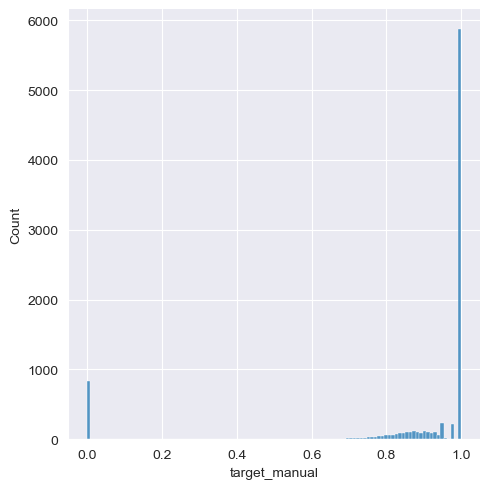

In [66]:
sns.displot(df['target_manual'])
plt.show()

In [255]:
word_tokenize(df.loc[4472, 'answer'])
df[df['answer']=='Stainless steel.']

['Stainless', 'steel', '.']

In [104]:
df[df['answer'].str.contains('.*\d.*')][['question','question_word','answer']].head(100)

,question,question_word,answer
1,model number,NaN,This may help InSinkErator Model BADGER-1: Bad...
13,My present disposal has a 3 bolt connection. W...,would,If I understand your present disposal 3 bolts ...
37,"how many strips come in the kit, I need at lea...",how,The kit contains ONE strip per test. So if you...
46,filter for vicks3,NaN,Filter for vicks3 is NOT a question. What are ...
47,I have not purchased the humidifier that uses ...,how,The outer shell will fall apart in about a yea...
...,...,...,...
305,what is the size of the duct vent,what,"This range hood has three knock-outs- a 3-1/4""..."
306,Price is pretty cheap. Is it strong?,is,"I purchased this 1-1/2 years ago, it was easy ..."
308,The Halogen bulbs are not very energy efficien...,are,There are LED bulbs available that are the sam...
310,"description says halogen bulbs, but they are n...",is,There are LED bulbs available that are the sam...


In [43]:
word_tokenize(re.sub('[\'_()./]',' ', 'no..still need a hood vent'.lower()))

['no', 'still', 'need', 'a', 'hood', 'vent']

In [98]:
qs = 'Where is it made?'
A1 = 'China'
A2 = 'Yes it does.'
A3 = 'The colour I looked over were grey, violet and white. I have a friend who bought it on white and it got dirty within a week! So I\'d recommend the darker colours for it if you can get them. Don\'t think there was a difference in price...'

print(f'A1 sim is {qa_sim(cleaner(qs), cleaner(A1))}')
print(f'A2 sim is {qa_sim(cleaner(qs), cleaner(A2))}')
print(f'A3 sim is {qa_sim(cleaner(qs), cleaner(A3))}')

Qs =  'Would you recommend this hardcover version of the book, since it\'s a bit more expensive?'
A1 = 'The book was absolutely AMAZING! Easily one of my favourite lectures so far this year. The story was highly immersive and (without giving away spoilers!) the character development the main trio was done excellently.'
A2 = 'I bought another version without the hardcover which you can find here [link]. It was $3 cheaper than the one here and read just fine. Depends if you\'re a collector I guess'
A3 = 'The hardcover makes this version of the book a little bit more expensive indeed'

print(f'A1 sim is {qa_sim(cleaner(qs), cleaner(A1))}')
print(f'A2 sim is {qa_sim(cleaner(qs), cleaner(A2))}')
print(f'A3 sim is {qa_sim(cleaner(qs), cleaner(A3))}')

A1 sim is 0.1620948398287978
A2 sim is 0.6894043346118088
A3 sim is 0.6614367317274487
A1 sim is 0.7280519361701034
A2 sim is 0.6630797660842995
A3 sim is 0.6764641370072577


In [86]:
df['sim_score'] = df.apply(lambda x: qa_sim(cleaner(x.question), cleaner(x.answer)), axis=1)

/var/folders/b7/kmbr2qfj1fd5c0wjsnnd0jtw0000gn/T/ipykernel_20585/3473484234.py:13: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return q_token.similarity(a_token)


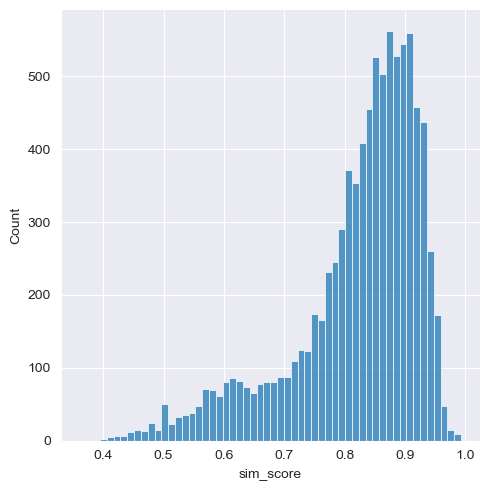

In [90]:
sns.displot((df['sim_score']+1)/2)
plt.show()

In [96]:
df[df['sim_score']<0.8][['question','question_word','answer', 'sim_score']].sort_values(by='sim_score').tail(10)

,question,question_word,answer,sim_score
8895,What brand and how much detergent should be me...,what,It depends on the level and fabric of clothes....,0.799607
4296,Non air gap or air gap?,NaN,this one is a Non air gap,0.799709
6686,is it easy to install,is,"I wouldn't call it easy, it take quite a bit o...",0.799739
3161,Will this item fit a Norcold1200 LRIM refriger...,will,"Yes, This will fit your Norcold1200LRIM refrig...",0.799764
1163,Does this filter work with RSG257AARS Samsung ...,does,"Not sure--I have model RFG237AARS, manufacture...",0.799782
8451,How much does this unit weigh?,how,Not sure the exact weight but it is a two man ...,0.799822
8344,Will this filter work with Samsung RF31FMESBSR...,will,If your refrigerator uses the DA29-00020B Sams...,0.799851
3595,What else do I need to buy besides a Keg in or...,what,You will need to fill the co2 tank. Personally...,0.799888
7093,"50 lbs. of ""ice storage"" . . . does that mean ...",will,It will not. Ice will last for hours not days ...,0.799991
4270,How many amps and what type of connection does...,what,"It comes wit a plug on it, so I put a receptac...",0.799992


## Test logreg model using new usefulness score

In [63]:
df['target_thresh'] = np.where(df['target_manual']>.8, 1, 0)

In [64]:
X = df['answer'].apply(cleaner)
y = df['target_thresh']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Fit model to train set
train_features = vectorizer.fit_transform(X_train)
train_features = train_features.toarray()
lr = LogisticRegression(max_iter=300)
lr.fit(train_features, y_train)
print(f'Mean accuracy is {lr.score(train_features, y_train)}')

Mean accuracy is 0.9765538290788013


In [65]:
# Use same model on test set
test_features = vectorizer.transform(X_test)
test_features = test_features.toarray()
print(f'Mean accuracy is {lr.score(test_features, y_test)}')

Mean accuracy is 0.947310038824182


## Semantic similarity using gensim

In [30]:
docs = word_tokenize(df['answer'][0])

In [28]:
from gensim.test.utils import datapath
from gensim import utils

class MyCorpus(object):
    """An interator that yields sentences (lists of str)."""

    def __iter__(self):
        corpus_path = df['answer']
        for line in corpus_path:
            # assume there's one document per line, tokens separated by whitespace
            yield utils.simple_preprocess(line)

In [29]:
sentences = MyCorpus()
model = models.Word2Vec(sentences=sentences)

In [106]:
model.wv['and']

array([-0.2583426 ,  0.31069326,  0.2164914 , -0.09980948,  0.44844946,
       -0.17867763,  0.23834953,  0.6720338 ,  0.20602371, -0.10191935,
        0.09840434, -0.22114341, -0.44414008,  0.07196458,  0.14214203,
       -0.14886281,  0.59420085, -0.18208332, -0.1816641 , -0.81400865,
        0.21141252,  0.1992026 ,  0.08699098, -0.09348352,  0.04392689,
        0.06513627,  0.24500507,  0.04792747,  0.090463  ,  0.36980525,
        0.0426644 ,  0.21531896, -0.16554886, -0.27656022, -0.09698725,
        0.18075915,  0.12838183, -0.35850653,  0.07015026, -0.43546847,
        0.12260643, -0.56154126,  0.2219886 ,  0.33743018,  0.3705482 ,
        0.06099876, -0.42395332,  0.06842229, -0.01824115,  0.336689  ,
        0.41008773, -0.07236537,  0.06786004, -0.11230028, -0.43372014,
        0.26053828,  0.05238849,  0.0676363 , -0.27290377, -0.04028637,
        0.00378138,  0.01982141, -0.06465166, -0.00430816, -0.12677051,
       -0.11242264, -0.11441474,  0.66312945, -0.5571406 , -0.10

In [105]:
for index, word in enumerate(model.wv.index_to_key):
    if index == 10:
        break
    print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")

word #0/3282 is the
word #1/3282 is it
word #2/3282 is to
word #3/3282 is and
word #4/3282 is is
word #5/3282 is you
word #6/3282 is of
word #7/3282 is for
word #8/3282 is in
word #9/3282 is that


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array([0, 1, 2, 3])
y = np.array([3, 8, 1, 10])

plt.subplot(2, 3, 1)
plt.plot(x,y)

x = np.array([0, 1, 2, 3])
y = np.array([10, 20, 30, 40])

plt.subplot(2, 3, 2)
plt.plot(x,y)

x = np.array([0, 1, 2, 3])
y = np.array([3, 8, 1, 10])

plt.subplot(2, 3, 3)
plt.plot(x,y)

x = np.array([0, 1, 2, 3])
y = np.array([10, 20, 30, 40])

plt.subplot(2, 3, 4)
plt.plot(x,y)

x = np.array([0, 1, 2, 3])
y = np.array([3, 8, 1, 10])

plt.subplot(2, 3, 5)
plt.plot(x,y)

x = np.array([0, 1, 2, 3])
y = np.array([10, 20, 30, 40])

plt.subplot(2, 3, 6)
plt.plot(x,y)

plt.show()#%%
import pandas as pd
import numpy as np
import gzip
import seaborn as sns
import matplotlib.pyplot as plt

import os
import itertools
from collections import Counter
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split # module to split our data into train and test sets

In [ ]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [ ]:
# Import and tidy dataframe (drop nulls)
df = getDF('qa_Appliances.json.gz')
#df.dropna(subset='answerType', inplace=True)
df = df.reset_index()

In [ ]:
df.loc[3,['question','questionType','answerType','answer']]

In [ ]:
df['questionType'].value_counts()

# Supervised Approach

In [ ]:
# Map answers to useful/not useful
df['target'] = df['answerType'].map({'Y':1, 'N':1, '?':0})

In [ ]:
## Transform a sentence into 1s and 0s
vectorizer = CountVectorizer(analyzer = "word", # What are we looking for?
                             tokenizer = None, # Already tokenised
                             preprocessor = None, # Already pre-processed
                             stop_words = None, # Already removed stopwords
                             max_features = 5000,
                             ngram_range=(1, 2)) # Determines the top X words used for the vectoriser

In [ ]:
train_features = vectorizer.fit_transform(df['answer'])
train_features = train_features.toarray()
y_train = df['target'].values
lr = LogisticRegression(max_iter=300)
lr.fit(train_features, y_train)
lr.score(train_features, y_train)

In [ ]:
df.loc[3,['question', 'answer']]

In [ ]:
# Check a single entry, 0 = unhelpful, 1 = helpful
test = vectorizer.transform(df.loc[3,['answer']])
lr.predict(test.toarray())

# Unsupervised approach
## Semantic similarity using spacy
### Between characteristic words and the answer

In [ ]:
import spacy
nlp = spacy.load('en_core_web_md')

In [ ]:
useful_words = 'yes,no,certainly,cant,can'.split(',')
un_words = 'unsure,never,dont,maybe,could'.split(',')

def similarity_test(list,answer):
    """
    Function to test the similarity between all the words of a sentence (answer) and a list of
    words (useful or useless words).
    Output is an average similarity score for the answer, between -1 and 1.
    """
    ans_sim = []
    use_sim = []

    for word in list:
        for term in answer:
            test_word = nlp(word)
            ans_word = nlp(term)
            ans_sim.append(test_word.similarity(ans_word))
        use_sim.append(sum(ans_sim)/len(ans_sim))
        print(word, sum(ans_sim)/len(ans_sim))
    return sum(use_sim)/len(use_sim)

ans = df['answer'][2].lower()
use_score = similarity_test(useful_words,ans.split(' '))
unu_score = similarity_test(un_words,ans.split(' '))

print(ans)
print(f'Useful score: {use_score}, unuseful score: {unu_score}')


### Between the question and the answer

In [ ]:
def qa_sim(question, answer):
    """
    Function to provide a similarity score between two sentences (question and answer),
    returned score is between -1 and 1
    """
    test_question = question
    test_answer = answer

    # Create a token for the test movie and initialise the highest coefficient marker
    q_token = nlp(test_question)
    a_token = nlp(test_answer)

    return q_token.similarity(a_token)

df['sim_score'] = df.apply(lambda x: qa_sim(x.question, x.answer), axis=1)

In [ ]:
df[['question','answer','sim_score']].sort_values(by='sim_score').head()

In [ ]:
df[['question','answer','sim_score']].sort_values(by='sim_score').tail()

In [ ]:
df.loc[6056,['answer','question']]

# Create a more accurate target value
### Extract the question word from the question

In [ ]:
#lemmatizer = WordNetLemmatizer()
#p_stemmer = PorterStemmer() Neither of these , turn 'does' -> 'do', so cannot use for 'what's' -> 'what'
qword_options = []
q_words = ['what', 'when', 'where', 'who', 'whom', 'which', 'whose', 'why', 'how', 'is', 'are', 'will', 'would', 'can', 'could', 'should', 'does', 'do', 'did', 'has', 'have', 'am', 'may'] # These are in order of priority when picking the question word
def extract_q(question):
    # for word in [p_stemmer.stem(x) for x in word_tokenize(question.lower())]:
    answer_list =  word_tokenize(question.lower())
    if bool(set(q_words) & set(answer_list)):
        word_out = [x for x in q_words if x in answer_list][0]
    else:
        word_out = np.nan
    return word_out

df['question_word'] = df['question'].apply(extract_q)
df['question_word'].value_counts()

In [ ]:
df[df['question_word']=='how'][['question','answerType','answer']].head()

### Process data to generate a usefulness score

In [2]:
from nltk.util import ngrams

def extract_ngrams(data, num):
    n_grams = ngrams(word_tokenize(data), num)
    return [ ' '.join(grams) for grams in n_grams]

def check_numeric(question, answer):

    if bool(re.search('.*\d.*', answer)) or bool(set(word_tokenize(answer)) & set(word_nums)):
        use_score = 1
    elif len(word_tokenize(answer))<4:
        use_score = 0.95
    else:
        use_score = (qa_sim(question, answer)+1)/2

    return use_score

def check_yn(question, answer):

    if bool(set(word_tokenize(answer)) & set(useful_words)):
        use_score = 1
    else:
        use_score = check_numeric(question, answer)

    return use_score

q_words = ['does', 'do', 'what', 'where', 'who', 'whom', 'which', 'whose', 'why', 'how', 'is', 'are', 'will', 'would', 'can', 'could', 'should',  'did', 'when','has', 'have', 'am', 'may']
yn_qs = ['is', 'are', 'will', 'would', 'can', 'could', 'should', 'may', 'does', 'do', 'did', 'has', 'have', 'am']
useful_words = ['yes', 'yea', 'sure', 'yep', 'yeah', 'indeed', 'certainly', 'definitely', 'cant', 'can', 'no', 'nope', 'nah']
un_words = ['unsure', 'never', 'maybe', 'could', 'probably', 'possibly']
unsure_bigrams = ['dont know', 'not sure', 'might do', 'could maybe', 'no idea', 'not know', 'a clue']
sure_bigrams = []
word_nums = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'eleven', 'twelve', 'teen', 'twenty', 'thirty', 'fourty', 'fifty', 'hundered', 'thousand']

def cleaner(text):

    text = re.sub('[!£$%^&*()_+{}:"|<>?~`,./;\[\]=-]',' ', text.lower())
    text = re.sub('[\']','', text.lower())

    text = word_tokenize(text)
    stpwrd = ['a', 'the', 'to', 'I', 'for']
    text = [word for word in text if word not in stpwrd]

    return ' '.join(text)

def useful_score(dframe):

    # Clean inputs
    question = cleaner(dframe['question'])
    answer = cleaner(dframe['answer'])

    if bool(set(extract_ngrams(answer, 2)) & set(unsure_bigrams)):
        # For any answer containing an 'unsure bigram', use_score = 0
        use_score = 0

    elif dframe['question_word'] in q_words:
        # For any clear question, an answer with y/n or with a number, has use_score = 1. Otherwise, similarity score is given.
        use_score = check_yn(question, answer)

    elif bool(re.search('.*\d.*', answer)) or \
            bool(set(word_tokenize(answer)) & set(word_nums)) or \
            bool(set(word_tokenize(answer)) & set(useful_words)):
        # Any other answer with y/n or a number, use_score = 0.98
        use_score = 0.98

    elif bool(set(word_tokenize(answer)) & set(un_words)):
        # Any other answer with un-useful words has use_score = 0.2
        use_score = 0.2

    elif len(word_tokenize(answer))<4:
        # Any short answer (3 or fewer words) is usually useful
        use_score = 0.95
    else:
        # Any other answer is scored by similarity between Q and A
        use_score = (qa_sim(question,answer)+1)/2
    return use_score


df['target_manual'] = df.apply(useful_score, axis=1)

NameError: name 'df' is not defined

In [ ]:
df.sort_values(by='target_manual').reset_index().loc[1220:1300,['question','answer','target_manual']]

In [ ]:
sns.displot(df['target_manual'])
plt.show()

In [ ]:
word_tokenize(df.loc[4472, 'answer'])
df[df['answer']=='Stainless steel.']

In [ ]:
df[df['answer'].str.contains('.*\d.*')][['question','question_word','answer']].head(100)

In [ ]:
word_tokenize(re.sub('[\'_()./]',' ', 'no..still need a hood vent'.lower()))

In [ ]:
qs = 'Where is it made?'
A1 = 'China'
A2 = 'Yes it does.'
A3 = 'The colour I looked over were grey, violet and white. I have a friend who bought it on white and it got dirty within a week! So I\'d recommend the darker colours for it if you can get them. Don\'t think there was a difference in price...'

print(f'A1 sim is {qa_sim(cleaner(qs), cleaner(A1))}')
print(f'A2 sim is {qa_sim(cleaner(qs), cleaner(A2))}')
print(f'A3 sim is {qa_sim(cleaner(qs), cleaner(A3))}')

Qs =  'Would you recommend this hardcover version of the book, since it\'s a bit more expensive?'
A1 = 'The book was absolutely AMAZING! Easily one of my favourite lectures so far this year. The story was highly immersive and (without giving away spoilers!) the character development the main trio was done excellently.'
A2 = 'I bought another version without the hardcover which you can find here [link]. It was $3 cheaper than the one here and read just fine. Depends if you\'re a collector I guess'
A3 = 'The hardcover makes this version of the book a little bit more expensive indeed'

print(f'A1 sim is {qa_sim(cleaner(qs), cleaner(A1))}')
print(f'A2 sim is {qa_sim(cleaner(qs), cleaner(A2))}')
print(f'A3 sim is {qa_sim(cleaner(qs), cleaner(A3))}')

In [ ]:
df['sim_score'] = df.apply(lambda x: qa_sim(cleaner(x.question), cleaner(x.answer)), axis=1)

In [ ]:
sns.displot((df['sim_score']+1)/2)
plt.show()

In [ ]:
df[df['sim_score']<0.8][['question','question_word','answer', 'sim_score']].sort_values(by='sim_score').tail(10)

## Test logreg model using new usefulness score

In [ ]:
df['target_thresh'] = np.where(df['target_manual']>.8, 1, 0)

In [ ]:
X = df['answer'].apply(cleaner)
y = df['target_thresh']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Fit model to train set
train_features = vectorizer.fit_transform(X_train)
train_features = train_features.toarray()
lr = LogisticRegression(max_iter=300)
lr.fit(train_features, y_train)
print(f'Mean accuracy is {lr.score(train_features, y_train)}')

In [ ]:
# Use same model on test set
test_features = vectorizer.transform(X_test)
test_features = test_features.toarray()
print(f'Mean accuracy is {lr.score(test_features, y_test)}')

## Semantic similarity using gensim

In [ ]:
docs = word_tokenize(df['answer'][0])

In [ ]:
from gensim.test.utils import datapath
from gensim import utils

class MyCorpus(object):
    """An interator that yields sentences (lists of str)."""

    def __iter__(self):
        corpus_path = df['answer']
        for line in corpus_path:
            # assume there's one document per line, tokens separated by whitespace
            yield utils.simple_preprocess(line)

In [ ]:
sentences = MyCorpus()
model = models.Word2Vec(sentences=sentences)

In [ ]:
model.wv['and']

In [ ]:
for index, word in enumerate(model.wv.index_to_key):
    if index == 10:
        break
    print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")